In [1]:
from __future__ import print_function
from glob import glob
from helpers import merge, count_params, cache_result
from random import randint
from zap50k import zap_data, IMAGE_SIZE
import itertools
import json
import math
import numpy as np
import os
import scipy.misc
import tensorflow as tf
import time

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

In [3]:
slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

TINY = 1e-8

In [4]:
#########
# Flags #
#########

flags = tf.app.flags
flags.DEFINE_string("file_pattern", "../data/ut-zap50k-images/*/*/*/*.jpg", "Pattern to find zap50k images")
flags.DEFINE_string("logdir", "./logdir", "Directory to save logs")
flags.DEFINE_string("sampledir", None, "Directory to save samples")
flags.DEFINE_boolean("classifier", False, "Use the discriminator for classification")
flags.DEFINE_boolean("kmeans", False, "Run kmeans of intermediate features")
flags.DEFINE_boolean("similarity", True, "Find most similar shoe")
flags.DEFINE_integer("batch_size", 32, "The size of batch images [32]")
flags.DEFINE_boolean("debug", False, "True if debug mode")
FLAGS = flags.FLAGS

if FLAGS.debug:
    tf.set_random_seed(1)
    np.random.seed(1)

##################
# Model settings #
##################

Z_DIM = 80
C_DIM = 8
C_COEFF = .05

In [5]:
##########
# Models #
##########


def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def generator(z, latent_c):
    depths = [32, 64, 64, 64, 64, 64, 3]
    sizes = zip(
        np.linspace(4, IMAGE_SIZE['resized'][0], len(depths)).astype(np.int),
        np.linspace(6, IMAGE_SIZE['resized'][1], len(depths)).astype(np.int))
    with slim.arg_scope([slim.conv2d_transpose],normalizer_fn=slim.batch_norm,kernel_size=3):
        with tf.variable_scope("gen"):
            size = sizes.pop(0)
            net = tf.concat(axis=1, values=[z, latent_c])
            net = slim.fully_connected(net, depths[0] * size[0] * size[1])
            net = tf.reshape(net, [-1, size[0], size[1], depths[0]])
            for depth in depths[1:-1] + [None]:
                net = tf.image.resize_images(net, sizes.pop(0),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                if depth:
                    net = slim.conv2d_transpose(net, depth)
            net = slim.conv2d_transpose(net, depths[-1], activation_fn=tf.nn.tanh, stride=1, normalizer_fn=None)
            tf.summary.image("gen", net, max_outputs=8)
    return net


def discriminator(input, reuse, dropout, int_feats=False, c_dim=None):
    depths = [16 * 2**x for x in range(5)] + [16]
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                        reuse=reuse,
                        normalizer_fn=slim.batch_norm,
                        activation_fn=lrelu):
        with tf.variable_scope("discr"):
            net = input
            for i, depth in enumerate(depths):
                if i != 0:
#                    net = slim.dropout(net, dropout, scope='dropout')
                    net = slim.dropout(net, 0.5, scope='dropout')
                if i % 2 == 0:
                    net = slim.conv2d(
                        net, depth, kernel_size=3, stride=2, scope='conv%d' % i)
                else:
                    net = slim.conv2d(
                        net, depth, kernel_size=3, scope='conv%d' % i)
            net = slim.flatten(net)
            if int_feats:
                return net
            else:
                d_net = slim.fully_connected(
                    net, 1, activation_fn=tf.nn.sigmoid, normalizer_fn=None, scope='out')
    if c_dim:
        with tf.variable_scope('latent_c'):
            q_net = slim.fully_connected(
                net, c_dim, activation_fn=tf.nn.tanh, scope='out')
        return d_net, q_net
    return d_net


def loss(d_model, g_model, dg_model, q_model, latent_c):
    t_vars = tf.trainable_variables()
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Latent_C
    q_loss = tf.reduce_sum(0.5 * tf.square(latent_c - q_model)) * C_COEFF

    # Discriminator
    d_loss = -tf.reduce_mean(tf.log(d_model + TINY) + tf.log(1. - dg_model + TINY))
    tf.summary.scalar('d_loss', d_loss)
    d_trainer = tf.train.AdamOptimizer(.0002, beta1=.5).minimize(
        d_loss + q_loss,
        global_step=global_step,
        var_list=[v for v in t_vars if 'discr/' in v.name or 'latent_c/' in v.name])

    # Generator
    g_loss = -tf.reduce_mean(tf.log(dg_model + TINY))
    tf.summary.scalar('g_loss', g_loss)
    g_trainer = tf.train.AdamOptimizer(.001, beta1=.5).minimize(
        g_loss + q_loss,
        var_list=[v for v in t_vars if 'gen/' in v.name or 'latent_c/' in v.name])

    return d_trainer, d_loss, g_trainer, g_loss, global_step


#######
# GAN #
#######


def gan(dataset, sess):
    # Model
    x = tf.placeholder(tf.float32, shape=[
        None, IMAGE_SIZE['resized'][0], IMAGE_SIZE['resized'][1], 3])
    dropout = tf.placeholder(tf.float32)
    d_model = discriminator(x, reuse=False, dropout=dropout)

    z = tf.placeholder(tf.float32, shape=[None, Z_DIM])
    latent_c = tf.placeholder(shape=[None, C_DIM], dtype=tf.float32)
    g_model = generator(z, latent_c)
    dg_model, q_model = discriminator(
        g_model, reuse=True, dropout=dropout, c_dim=C_DIM)

    d_trainer, d_loss, g_trainer, g_loss, global_step = loss(
        d_model, g_model, dg_model, q_model, latent_c)

    # Stats
    t_vars = tf.trainable_variables()
    count_params(t_vars, ['discr/', 'gen/', 'latent_c/'])
    # for v in t_vars:
    # tf.histogram_summary(v.name, v)

    # Init
    summary = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(FLAGS.logdir, sess.graph)
    tf.global_variables_initializer().run()

    # Saver
    saver = tf.train.Saver(max_to_keep=10)
    checkpoint = tf.train.latest_checkpoint(FLAGS.logdir)
    if checkpoint:
        print('Restoring from', checkpoint)
        saver.restore(sess, checkpoint)

    # Dataset queue
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    tf.train.start_queue_runners(sess=sess)

    # Training loop
    for step in range(global_step.eval(), 1 if FLAGS.debug else int(1e6)):
        z_batch = np.random.uniform(-1, 1, [FLAGS.batch_size, Z_DIM]).astype(np.float32)
        c_batch = np.random.uniform(-1, 1, [FLAGS.batch_size, C_DIM])
        images, _ = sess.run(dataset['batch'])
        feed_dict = {z: z_batch, latent_c: c_batch, x: images, dropout: .5, }

        # Update discriminator
        start = time.time()
        _, d_loss_val = sess.run([d_trainer, d_loss], feed_dict=feed_dict)
        d_time = time.time() - start

        # Update generator
        start = time.time()
        _, g_loss_val, summary_str = sess.run([g_trainer, g_loss, summary], feed_dict=feed_dict)
        g_time = time.time() - start

        # Log details
        if step % 10 == 0 or FLAGS.debug:
            print("[%s, %s] Disc loss: %.3f (%.2fs), Gen Loss: %.3f (%.2fs)" %
                  (step, step * FLAGS.batch_size / dataset['size'], d_loss_val, d_time, g_loss_val, g_time, ))
            summary_writer.add_summary(summary_str, global_step.eval())

        # Early stopping
        if np.isnan(g_loss_val) or np.isnan(d_loss_val):
            print('Early stopping', g_loss_val, d_loss_val)
            break

        # save model
        if step % 1000 == 0 and not FLAGS.debug:
            print('Saving')
            checkpoint_file = os.path.join(FLAGS.logdir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=global_step)

    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)
    return


##########
# Sample #
##########

def sample(FLAGS, sess):
    # Model
    z = tf.placeholder(tf.float32, shape=[None, Z_DIM])
    latent_c = tf.placeholder(shape=[None, C_DIM], dtype=tf.float32)
    g_model = generator(z, latent_c)

    # Restore
    saver = tf.train.Saver()
    checkpoints = [x for x in glob(FLAGS.logdir + '/checkpoint-*') if 'meta' not in x]
    checkpoints = [tf.train.latest_checkpoint(FLAGS.logdir)]
    for checkpoint in checkpoints:
        saver.restore(sess, checkpoint)

        # Save samples
        output = "samples/%s.png" % os.path.basename(checkpoint)
        samples = 144
        width = math.sqrt(samples)

        # Input
        z_batch = np.random.uniform(-1.0, 1.0, size=[samples, Z_DIM]).astype(np.float32)
        c_batch = np.zeros((samples, C_DIM))
        if 0:
            for i in range(8):
                c_batch[i * width:(i + 1) * width, i] = np.linspace(-1, 1, width)
        else:
            c_batch[:, 0] = np.tile(np.linspace(-1, 1, width), width)
            c_batch[:, 1] = np.repeat(np.linspace(-1, 1, width), width)

        # Run and save
        images = sess.run(g_model, feed_dict={z: z_batch, latent_c: c_batch})
        images = np.reshape(
            images, [samples, IMAGE_SIZE['resized'][0], IMAGE_SIZE['resized'][1], 3])
        images = (images + 1.) / 2.
        scipy.misc.imsave(output, merge(images, [int(width)] * 2))


##############
# Similarity #
##############

@cache_result
def export_intermediate(FLAGS, sess, dataset):
    # Models
    x = tf.placeholder(tf.float32, shape=[
        None, IMAGE_SIZE['resized'][0], IMAGE_SIZE['resized'][1], 3])
    dropout = tf.placeholder(tf.float32)
    feat_model = discriminator(x, reuse=False, dropout=dropout, int_feats=True)

    # Init
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    # Restore
    saver = tf.train.Saver()
    checkpoint = tf.train.latest_checkpoint(FLAGS.logdir)
    saver.restore(sess, checkpoint)

    # Run
    all_features = np.zeros((dataset['size'], feat_model.get_shape()[1]))
    all_paths = []
    for i in itertools.count():
        try:
            images, paths = sess.run(dataset['batch'])
        except tf.errors.OutOfRangeError:
            break
        if i % 10 == 0:
            print(i * FLAGS.batch_size, dataset['size'])
        im_features = sess.run(feat_model, feed_dict={x: images, dropout: 1, })
        all_features[FLAGS.batch_size * i:FLAGS.batch_size * i + im_features.shape[0]] = im_features
        all_paths += list(paths)

    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads)

    return all_features, all_paths

In [6]:
def select_images(distances):
    indices = np.argsort(distances)
    images = []
    size = 40
    for i in range(size):
        images += [dict(path=all_paths[indices[i]], index=indices[i], distance=distances[indices[i]])]
    return images


In [7]:
def similarity(FLAGS, sess, all_features, all_paths):
    def select_images(distances):
        indices = np.argsort(distances)
        images = []
        size = 40
        for i in range(size):
            images += [dict(path=all_paths[indices[i]], index=indices[i], distance=distances[indices[i]])]
        return images

    # Distance
    x1 = tf.placeholder(tf.float32, shape=[None, all_features.shape[1]])
    x2 = tf.placeholder(tf.float32, shape=[None, all_features.shape[1]])
    l2diff = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(x1, x2)), axis=1))

    # Init
    init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
    sess.run(init_op)

    #
    clip = 1e-3
    np.clip(all_features, -clip, clip, all_features)

    # Get distances
    result = []
    bs = 100
    needles = [randint(0, all_features.shape[0]) for x in range(10)]
    print(needles)
    for needle in needles:
        item_block = np.reshape(np.tile(all_features[needle], bs), [bs, -1])
        distances = np.zeros(all_features.shape[0])
        for i in range(0, all_features.shape[0], bs):
            if i + bs > all_features.shape[0]:
                bs = all_features.shape[0] - i
            distances[i:i + bs] = sess.run(
                l2diff, feed_dict={x1: item_block[:bs], x2: all_features[i:i + bs]})

        # Pick best matches
        result += [select_images(distances)]

    with open('data2.json', 'w') as f:
        json.dump(dict(data=result), f)
    return 

In [8]:
def similarityX(index, num, FLAGS, sess, all_features, all_paths):
    def select_images(num,distances):
        indices = np.argsort(distances)
        images = []
        size = num
        for i in range(size):
            images += [dict(path=all_paths[indices[i]], index=indices[i], distance=distances[indices[i]])]
        return images

    # Distance
    x1 = tf.placeholder(tf.float32, shape=[None, all_features.shape[1]])
    x2 = tf.placeholder(tf.float32, shape=[None, all_features.shape[1]])
    l2diff = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(x1, x2)), axis=1))

    # Init
    init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
    sess.run(init_op)

    #
    clip = 1e-3
    np.clip(all_features, -clip, clip, all_features)

    # Get distances
    result = []
    bs = 100
    needle = index
    item_block = np.reshape(np.tile(all_features[needle], bs), [bs, -1])
    distances = np.zeros(all_features.shape[0])
    for i in range(0, all_features.shape[0], bs):
        if i + bs > all_features.shape[0]:
            bs = all_features.shape[0] - i
        distances[i:i + bs] = sess.run(
            l2diff, feed_dict={x1: item_block[:bs], x2: all_features[i:i + bs]})

    # Pick best matches
    result1 = select_images(num,distances)
    result = [result1]
    with open('data3.json', 'w') as f:
        json.dump(dict(data=result), f)
    return result1

In [9]:
if not tf.gfile.Exists(FLAGS.logdir):
    tf.gfile.MakeDirs(FLAGS.logdir)
if FLAGS.sampledir and not tf.gfile.Exists(FLAGS.sampledir):
    tf.gfile.MakeDirs(FLAGS.sampledir)

In [10]:
sess = tf.Session()
dataset = zap_data(FLAGS, False)

In [11]:
# Models
x = tf.placeholder(tf.float32, shape=[
    None, IMAGE_SIZE['resized'][0], IMAGE_SIZE['resized'][1], 3])
dropout = tf.placeholder(tf.float32)
feat_model = discriminator(x, reuse=False, dropout=dropout, int_feats=True)

In [13]:
# Init
init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
sess.run(init_op)
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

In [14]:
# Restore
saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(FLAGS.logdir)
saver.restore(sess, checkpoint)

# Run
all_features = np.zeros((dataset['size'], feat_model.get_shape()[1]))
all_paths = []
for i in itertools.count():
    try:
        images, paths = sess.run(dataset['batch'])
    except tf.errors.OutOfRangeError:
        break
    if i % 10 == 0:
        print(i * FLAGS.batch_size, dataset['size'])
    im_features = sess.run(feat_model, feed_dict={x: images, dropout: 1, })
    all_features[FLAGS.batch_size * i:FLAGS.batch_size * i + im_features.shape[0]] = im_features
    all_paths += list(paths)

# Finish off the filename queue coordinator.
coord.request_stop()
coord.join(threads)

INFO:tensorflow:Restoring parameters from ./logdir/checkpoint-4001
0 50025
320 50025
640 50025
960 50025
1280 50025
1600 50025
1920 50025
2240 50025
2560 50025
2880 50025
3200 50025
3520 50025
3840 50025
4160 50025
4480 50025
4800 50025
5120 50025
5440 50025
5760 50025
6080 50025
6400 50025
6720 50025
7040 50025
7360 50025
7680 50025
8000 50025
8320 50025
8640 50025
8960 50025
9280 50025
9600 50025
9920 50025
10240 50025
10560 50025
10880 50025
11200 50025
11520 50025
11840 50025
12160 50025
12480 50025
12800 50025
13120 50025
13440 50025
13760 50025
14080 50025
14400 50025
14720 50025
15040 50025
15360 50025
15680 50025
16000 50025
16320 50025
16640 50025
16960 50025
17280 50025
17600 50025
17920 50025
18240 50025
18560 50025
18880 50025
19200 50025
19520 50025
19840 50025
20160 50025
20480 50025
20800 50025
21120 50025
21440 50025
21760 50025
22080 50025
22400 50025
22720 50025
23040 50025
23360 50025
23680 50025
24000 50025
24320 50025
24640 50025
24960 50025
25280 50025
25600 50025

In [15]:
#all_features, all_paths = export_intermediate(FLAGS, sess, dataset)

In [30]:
num = 1
index = 41000

In [31]:
result = similarityX(index,num,FLAGS, sess, all_features, all_paths)

In [32]:
def display_image(x):
    print(x['path'])
    img = mpimg.imread(x['path'])
    plt.imshow(img)
    plt.show()
    return

../data/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/Vans/7503678.307305.jpg


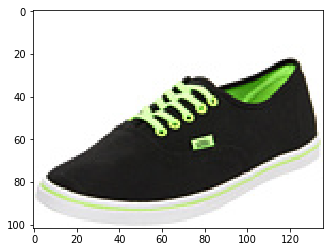

[None]

In [33]:
[display_image(x) for x in result]

In [34]:
num = 5

../data/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/Vans/7503678.307305.jpg


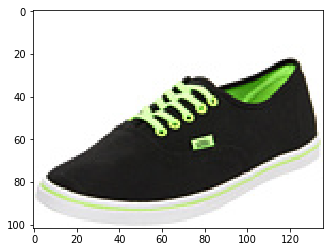

../data/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/ECCO/7703767.72.jpg


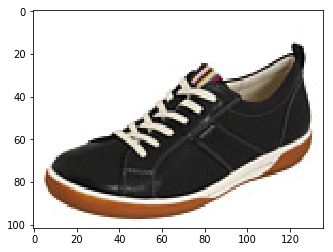

../data/ut-zap50k-images/Shoes/Boat Shoes/Tretorn/7890008.90022.jpg


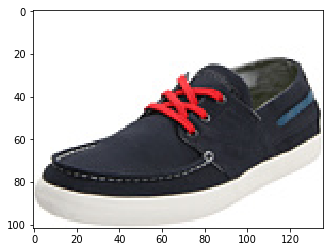

../data/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/Vans/7503678.348994.jpg


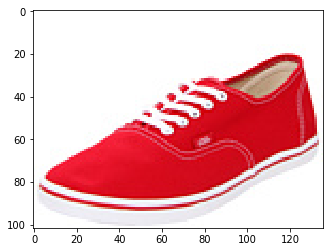

../data/ut-zap50k-images/Shoes/Loafers/Merrell/7659523.72.jpg


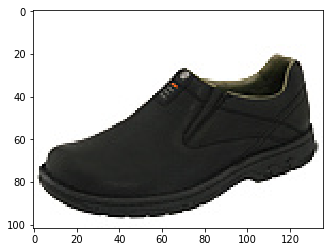

[None, None, None, None, None]

In [35]:
result = similarityX(index,num,FLAGS, sess, all_features, all_paths)
[display_image(x) for x in result]

-----------------------------------------------------------------------------